In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.pipeline import Pipeline

In [3]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
df = pd.read_csv('ETH-USD.csv')

In [6]:
df.head(5)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-01-01,782.530029,742.004028,755.757019,772.640991,2595760128,772.640991
1,2018-01-02,914.830017,772.346008,772.346008,884.443970,5783349760,884.443970
2,2018-01-03,974.471008,868.450989,886.000000,962.719971,5093159936,962.719971
3,2018-01-04,1045.079956,946.085999,961.713013,980.921997,6502859776,980.921997
4,2018-01-05,1075.390015,956.325012,975.750000,997.719971,6683149824,997.719971


In [7]:
df.tail(5)

,Date,High,Low,Open,Close,Volume,Adj Close
1776,2022-11-12,1288.150879,1242.152222,1287.438354,1255.268311,10964962767,1255.268311
1777,2022-11-13,1271.712524,1208.520996,1255.441284,1221.819214,10717455214,1221.819214
1778,2022-11-14,1284.217651,1178.429077,1221.895508,1241.604248,15028035663,1241.604248
1779,2022-11-15,1283.198730,1238.688232,1241.677734,1251.736206,11798011594,1251.736206
1780,2022-11-16,1264.168457,1192.987793,1252.425903,1210.270142,12423276544,1210.270142


In [8]:
df = df.drop('Date', axis=1)

In [9]:
df

,High,Low,Open,Close,Volume,Adj Close
0,782.530029,742.004028,755.757019,772.640991,2595760128,772.640991
1,914.830017,772.346008,772.346008,884.443970,5783349760,884.443970
2,974.471008,868.450989,886.000000,962.719971,5093159936,962.719971
3,1045.079956,946.085999,961.713013,980.921997,6502859776,980.921997
4,1075.390015,956.325012,975.750000,997.719971,6683149824,997.719971
...,...,...,...,...,...,...
1776,1288.150879,1242.152222,1287.438354,1255.268311,10964962767,1255.268311
1777,1271.712524,1208.520996,1255.441284,1221.819214,10717455214,1221.819214
1778,1284.217651,1178.429077,1221.895508,1241.604248,15028035663,1241.604248
1779,1283.198730,1238.688232,1241.677734,1251.736206,11798011594,1251.736206


### Signals

In [10]:
df['short_mavg'] = df['Close'].rolling(window=10, min_periods=1, center=False).mean()
df['long_mavg'] = df['Close'].rolling(window=60, min_periods=1, center=False).mean()
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

In [11]:
df.isnull().sum()

High          0
Low           0
Open          0
Close         0
Volume        0
Adj Close     0
short_mavg    0
long_mavg     0
signal        0
dtype: int64

### Feature engineer... now we add MAs, RSI, RoC, MOM, MACD, Stochs, etc

In [12]:
def SMA(df): #small moving average
    df['SMA_21days'] = df.iloc[:,3].rolling(window=21).mean()
    df['SMA_50days'] = df.iloc[:,3].rolling(window=50).mean()
    df['SMA_100days'] = df.iloc[:,3].rolling(window=100).mean()
    df['SMA_150days'] = df.iloc[:,3].rolling(window=150).mean()
SMA(df)

In [13]:
def EMA(df): #Exponential Moving Average
    df['EMA_21days'] = df['Close'].ewm(span=21,adjust=False).mean()
    df['EMA_50days'] = df['Close'].ewm(span=50,adjust=False).mean()
    df['EMA_100days'] = df['Close'].ewm(span=100,adjust=False).mean()
    df['EMA_150days'] = df['Close'].ewm(span=150,adjust=False).mean()
EMA(df)

In [14]:
def RSIs(df,n): #Relative Strength Index
    df['diff'] = df.Close.diff()
    df['pos'] = df['diff'].clip(lower=0)
    df['neg'] = -1*df['diff'].clip(upper=0)
    ema_pos = df['pos'].ewm(com=(n-1), adjust=False).mean()
    ema_neg = df['neg'].ewm(com=(n-1), adjust=False).mean()
    relative_str = ema_pos / ema_neg
    df['RSI'+str(n)] = 100-(100/(1+relative_str))
    df['Stochastic_RSI'+str(n)] = (df['RSI'+str(n)]-df['RSI'+str(n)].rolling(n).min())/(df['RSI'+str(n)].rolling(n).max()-(df['RSI'+str(n)].rolling(n).min()))
RSIs(df, 21)
RSIs(df, 50)
RSIs(df, 100)
RSIs(df, 150)

In [15]:
def ROC(df, n): #Rate of change
    M = df.diff(n-1)
    N = df.shift(n-1)
    ROC = pd.Series(((M/N)*100),name='Roc_'+str(n))
    return ROC
df['ROC21'] = ROC(df['Close'],21)
df['ROC50'] = ROC(df['Close'],50)
df['ROC100'] = ROC(df['Close'],100)
df['ROC150'] = ROC(df['Close'],150)

In [16]:
def MOM(df,n): #momentum
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM21'] = MOM(df['Close'], 21)
df['MOM50'] = MOM(df['Close'], 50)
df['MOM100'] = MOM(df['Close'], 100)
df['MOM150'] = MOM(df['Close'], 150)

In [17]:
def MACD(df): #default is 12-26-9
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1-exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
MACD(df)

In [18]:
def Stochastic(df,n):
    high = df['High'].rolling(n).max()
    low = df['Low'].rolling(n).min()
    df['%K'+str(n)] = (df['Close']-low)*100/(high-low) #current price in relation to the asset's recent price change
    df['%D'+str(n)] = df['%K'+str(n)].rolling(3).mean() #3 period average of %K
Stochastic(df,21)
Stochastic(df,50)
Stochastic(df,100)
Stochastic(df,150)

In [19]:
df.shape

(1781, 46)

In [20]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'short_mavg',
       'long_mavg', 'signal', 'SMA_21days', 'SMA_50days', 'SMA_100days',
       'SMA_150days', 'EMA_21days', 'EMA_50days', 'EMA_100days', 'EMA_150days',
       'diff', 'pos', 'neg', 'RSI21', 'Stochastic_RSI21', 'RSI50',
       'Stochastic_RSI50', 'RSI100', 'Stochastic_RSI100', 'RSI150',
       'Stochastic_RSI150', 'ROC21', 'ROC50', 'ROC100', 'ROC150', 'MOM21',
       'MOM50', 'MOM100', 'MOM150', 'MACD', 'Signal_Line', '%K21', '%D21',
       '%K50', '%D50', '%K100', '%D100', '%K150', '%D150'],
      dtype='object')

In [21]:
df = df.drop(['diff', 'pos', 'neg'],axis=1)

In [22]:
df.isnull().sum()

High                   0
Low                    0
Open                   0
Close                  0
Volume                 0
Adj Close              0
short_mavg             0
long_mavg              0
signal                 0
SMA_21days            20
SMA_50days            49
SMA_100days           99
SMA_150days          149
EMA_21days             0
EMA_50days             0
EMA_100days            0
EMA_150days            0
RSI21                  1
Stochastic_RSI21      21
RSI50                  1
Stochastic_RSI50      50
RSI100                 1
Stochastic_RSI100    100
RSI150                 1
Stochastic_RSI150    150
ROC21                 20
ROC50                 49
ROC100                99
ROC150               149
MOM21                 21
MOM50                 50
MOM100               100
MOM150               150
MACD                   0
Signal_Line            0
%K21                  20
%D21                  22
%K50                  49
%D50                  51
%K100                 99


In [23]:
df.shape

(1781, 43)

array([[<AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'Adj Close'}>,
        <AxesSubplot:title={'center':'short_mavg'}>],
       [<AxesSubplot:title={'center':'long_mavg'}>,
        <AxesSubplot:title={'center':'signal'}>,
        <AxesSubplot:title={'center':'SMA_21days'}>,
        <AxesSubplot:title={'center':'SMA_50days'}>,
        <AxesSubplot:title={'center':'SMA_100days'}>,
        <AxesSubplot:title={'center':'SMA_150days'}>,
        <AxesSubplot:title={'center':'EMA_21days'}>],
       [<AxesSubplot:title={'center':'EMA_50days'}>,
        <AxesSubplot:title={'center':'EMA_100days'}>,
        <AxesSubplot:title={'center':'EMA_150days'}>,
        <AxesSubplot:title={'center':'RSI21'}>,
        <AxesSubplot:title={'center':'Stochastic_RSI21'}>,
        <AxesSubplot

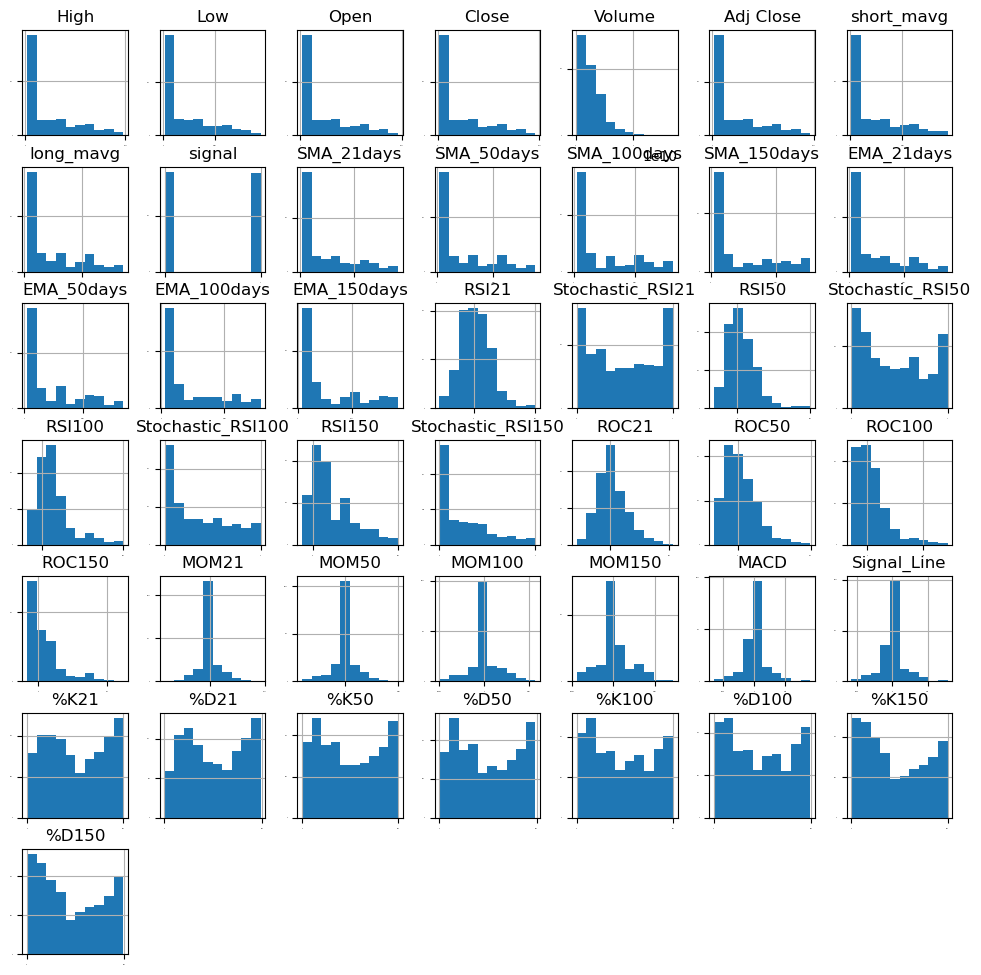

In [24]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))

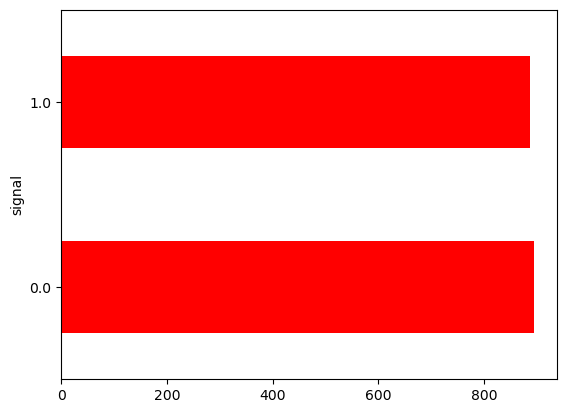

In [25]:
fig = plt.figure()
plot = df.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<AxesSubplot:>

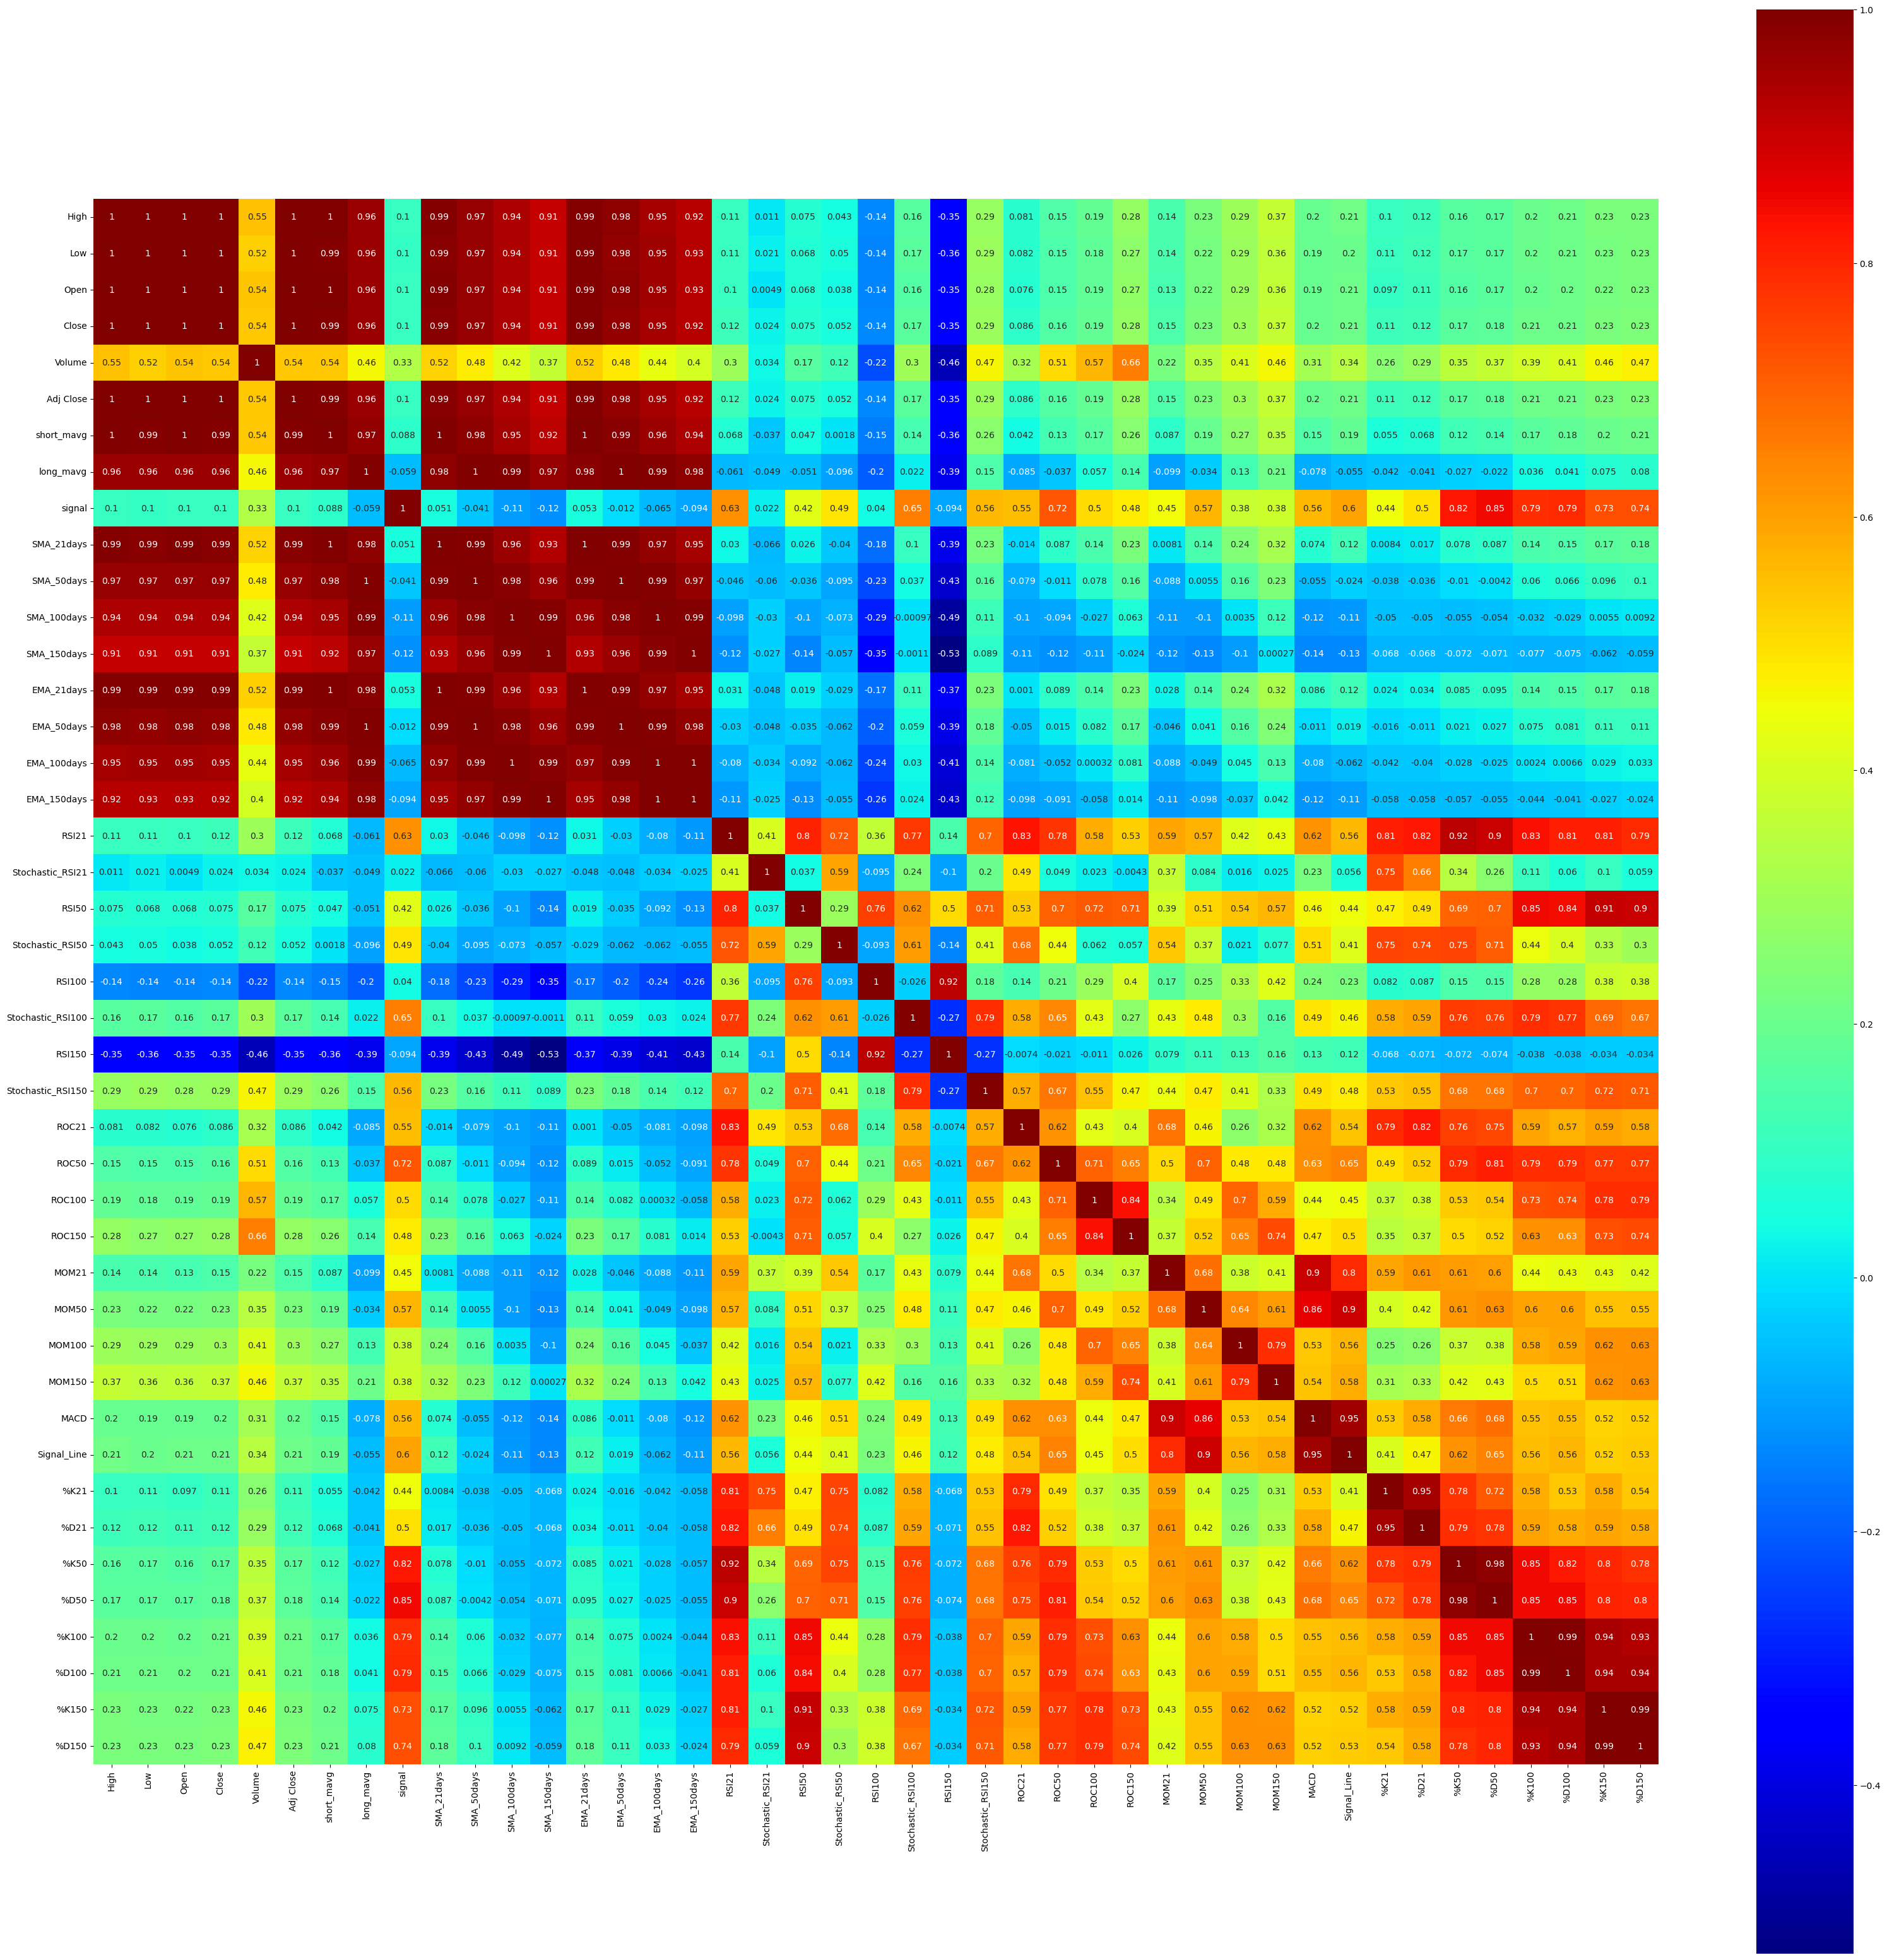

In [26]:
correlation = df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='jet')

In [27]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'short_mavg',
       'long_mavg', 'signal', 'SMA_21days', 'SMA_50days', 'SMA_100days',
       'SMA_150days', 'EMA_21days', 'EMA_50days', 'EMA_100days', 'EMA_150days',
       'RSI21', 'Stochastic_RSI21', 'RSI50', 'Stochastic_RSI50', 'RSI100',
       'Stochastic_RSI100', 'RSI150', 'Stochastic_RSI150', 'ROC21', 'ROC50',
       'ROC100', 'ROC150', 'MOM21', 'MOM50', 'MOM100', 'MOM150', 'MACD',
       'Signal_Line', '%K21', '%D21', '%K50', '%D50', '%K100', '%D100',
       '%K150', '%D150'],
      dtype='object')

In [28]:
df.shape

(1781, 43)

In [29]:
df = df.drop(['Open','High','Low', 'short_mavg','long_mavg'],axis=1)

In [30]:
df.columns

Index(['Close', 'Volume', 'Adj Close', 'signal', 'SMA_21days', 'SMA_50days',
       'SMA_100days', 'SMA_150days', 'EMA_21days', 'EMA_50days', 'EMA_100days',
       'EMA_150days', 'RSI21', 'Stochastic_RSI21', 'RSI50', 'Stochastic_RSI50',
       'RSI100', 'Stochastic_RSI100', 'RSI150', 'Stochastic_RSI150', 'ROC21',
       'ROC50', 'ROC100', 'ROC150', 'MOM21', 'MOM50', 'MOM100', 'MOM150',
       'MACD', 'Signal_Line', '%K21', '%D21', '%K50', '%D50', '%K100', '%D100',
       '%K150', '%D150'],
      dtype='object')

<AxesSubplot:>

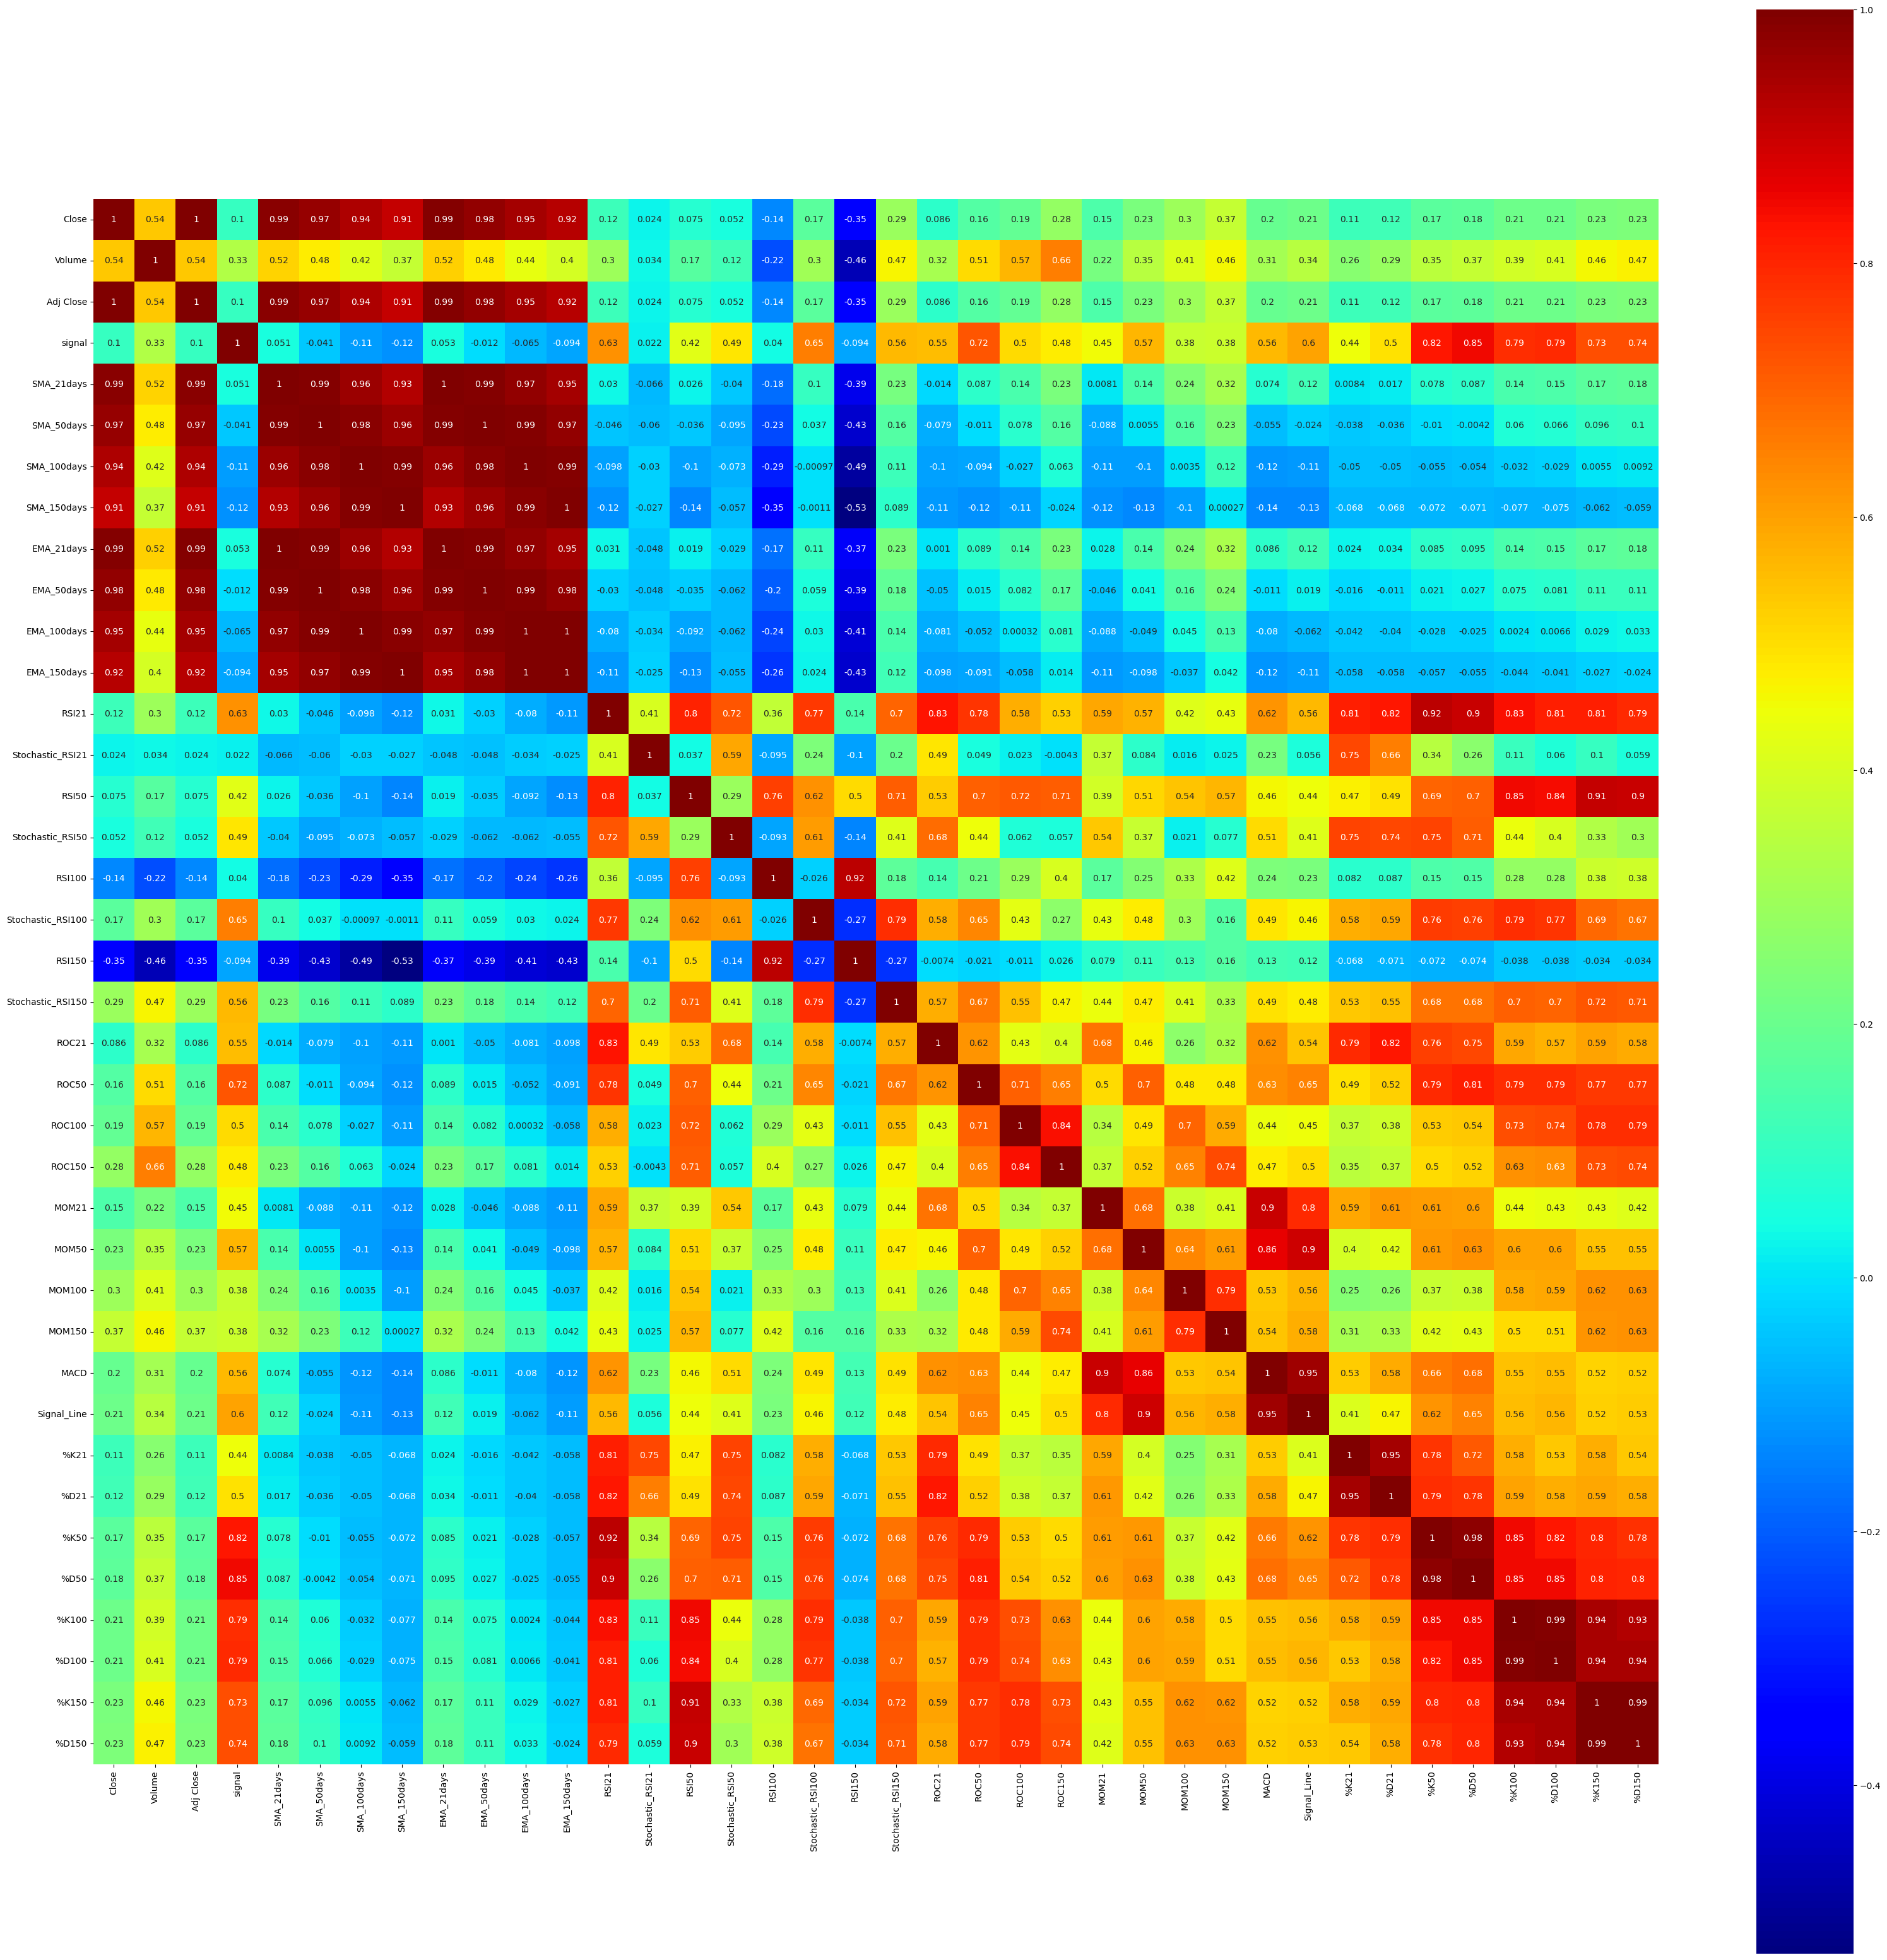

In [31]:
correlation = df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='jet')

In [32]:
val_size = 0.2
seed = 42
val = int(df.shape[0]*0.8)
subset = df.iloc[-val:]
X = subset.loc[:, df.columns != 'signal']
y = subset['signal']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=val_size, random_state=seed)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [34]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ETC', ExtraTreesClassifier()))
models.append(('SVC', SVC()))
models.append(('NB', GaussianNB()))

In [35]:
num_folds = 10
SEED = 43
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [36]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.589117 (0.034323)
KNN: 0.568964 (0.065313)
CART: 0.977170 (0.009777)
LDA: 0.964858 (0.016730)
NN: 0.529467 (0.090838)
AB: 0.978924 (0.008055)
GBM: 0.985934 (0.009835)
RF: 0.978916 (0.011273)
ETC: 0.970129 (0.013780)
SVC: 0.589117 (0.034323)
NB: 0.565463 (0.037324)


Saving figure ETH prediction - Models Evaluation


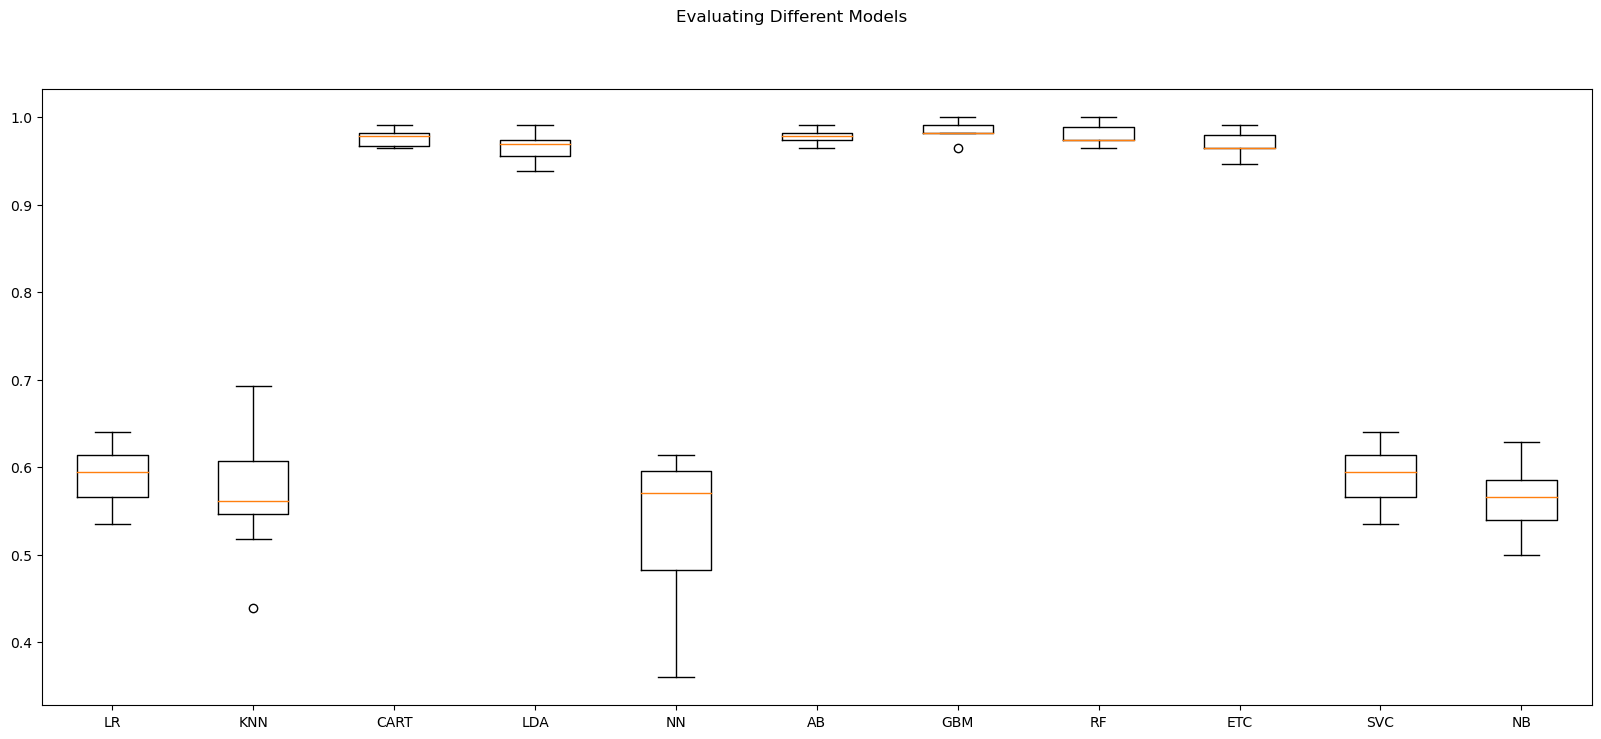

In [37]:
fig = plt.figure()
fig.suptitle('Evaluating Different Models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(20,8)
save_fig('ETH prediction - Models Evaluation', tight_layout=False)
plt.show()

LR, KNN, NN, SVC, NB seems to perform very poorly when our dataframe is presented, having expected nonlinear relationship between predicted variable and tthe features. 

CART, LDA, Adaboost, Grad boosting, RF are the best valid options of models to choose for the optimization process. We'll see how well the predictions are for each of them

In [38]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


In [39]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit(X_val)

In [40]:
n_estimators = [10,20,50,80,100]
max_depth=[1,2,3,4,5,6,7,8,9,10]
criterion = ['gini','entropy']
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [41]:
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print('#%d %f (%f) with %r' % (rank, mean, stdev, param))

Best: 0.985064 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#100 0.944683 (0.029381) with {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 10}
#97 0.954332 (0.019184) with {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 20}
#88 0.960472 (0.012032) with {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 50}
#93 0.958718 (0.016733) with {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 80}
#92 0.959587 (0.015907) with {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 100}
#83 0.965751 (0.015935) with {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}
#86 0.963989 (0.012743) with {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 20}
#74 0.970137 (0.009824) with {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50}
#89 0.960464 (0.017762) with {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 80}
#84 0.965735 (0.012182) with {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}
#77 0.969259 (0.015847) with {'criterion': 'gin

### FINALIZE MODEL

Modify the model again from the best criteria... criterion=entropy, max_depth = 10, n_estimator=80

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [55]:
model = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=20) #rbf is default kernel
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=20)

In [56]:
predictions = model.predict(X_val)

In [57]:
train_score = model.score(X_train, y_train)
train_score

1.0

In [58]:
test_score = model.score(X_val, y_val)
test_score

0.9649122807017544

In [60]:
print(accuracy_score(y_val, predictions))

0.9649122807017544


In [63]:
print(confusion_matrix(y_val, predictions))

[[111   5]
 [  5 164]]


In [64]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       116
         1.0       0.97      0.97      0.97       169

    accuracy                           0.96       285
   macro avg       0.96      0.96      0.96       285
weighted avg       0.96      0.96      0.96       285



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

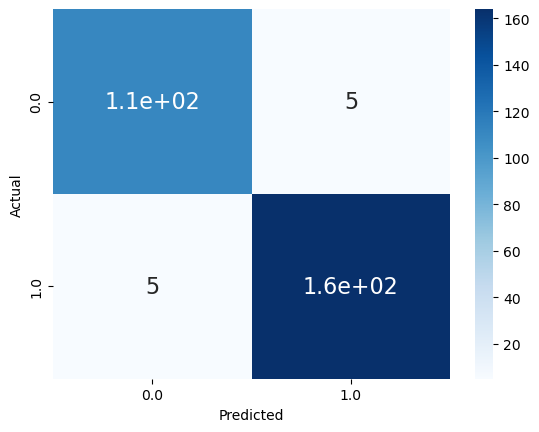

In [66]:
df_cm = pd.DataFrame(confusion_matrix(y_val, predictions), columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

Model predicts with 98% accuracy! POGGIES

Saving figure Feature Importance


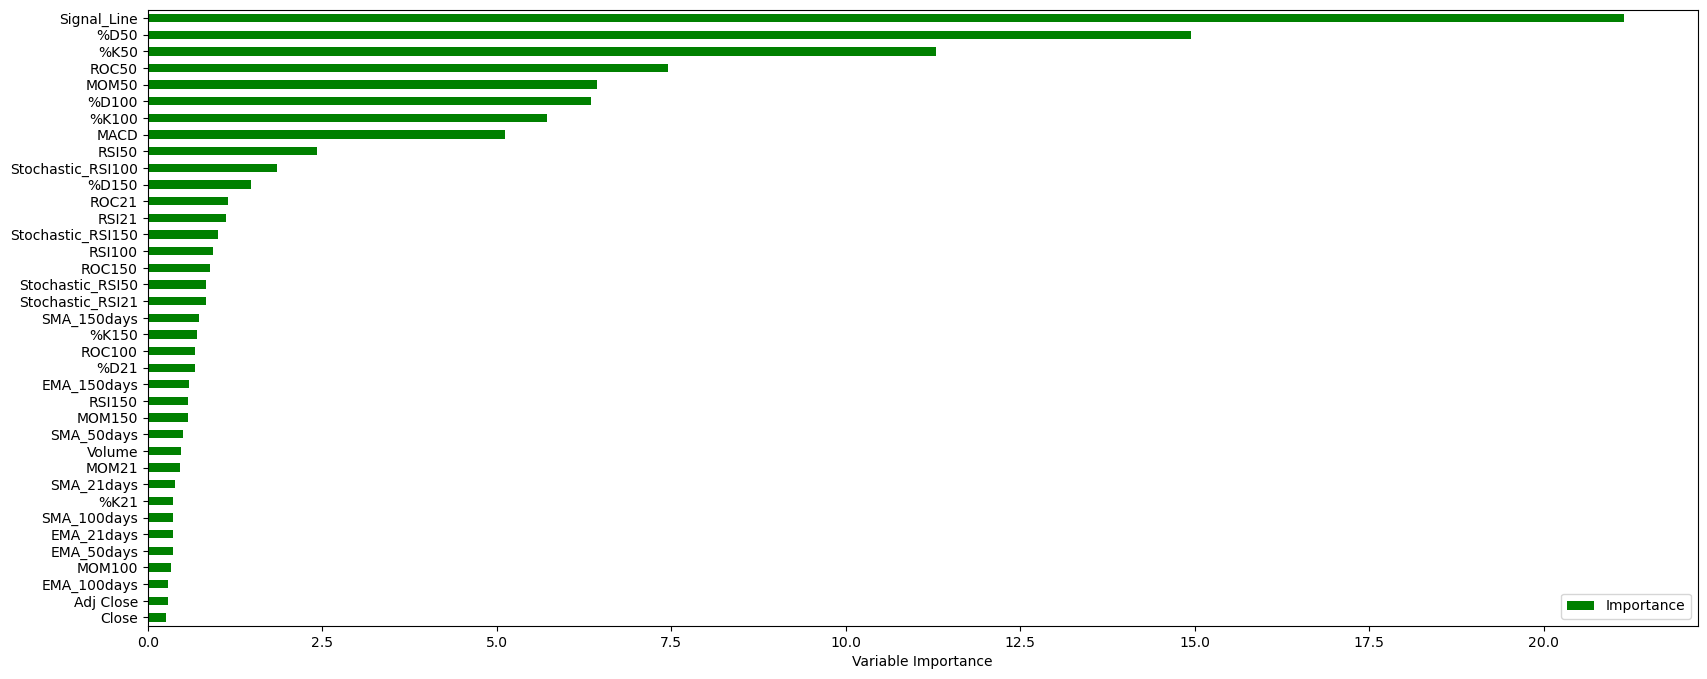

In [50]:
feat_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
feat_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='g', figsize=(20,8))
plt.xlabel('Variable Importance')
save_fig('Feature Importance', tight_layout=False)
plt.show()

### Backtesting

In [51]:
backtest = pd.DataFrame(index=X_val.index)
backtest['signal pred'] = predictions
backtest['signal actual'] = y_val
backtest['market return'] = X_val['Close'].pct_change()
backtest['actual return'] = backtest['market return'] * backtest['signal actual'].shift(1)
backtest['strat return'] = backtest['market return'] * backtest['signal pred'].shift(1)
backtest = backtest.reset_index()

In [52]:
backtest.head(5)

,index,signal pred,signal actual,market return,actual return,strat return
0,1542,1.0,1.0,NaN,NaN,NaN
1,1034,1.0,1.0,-0.872457,-0.872457,-0.872457
2,1441,0.0,0.0,9.694662,9.694662,9.694662
3,1362,0.0,1.0,-0.290917,-0.000000,-0.000000
4,1301,0.0,0.0,-0.252517,-0.252517,-0.000000


Saving figure Backtest - strat return vs actual return histogram


<Figure size 640x480 with 0 Axes>

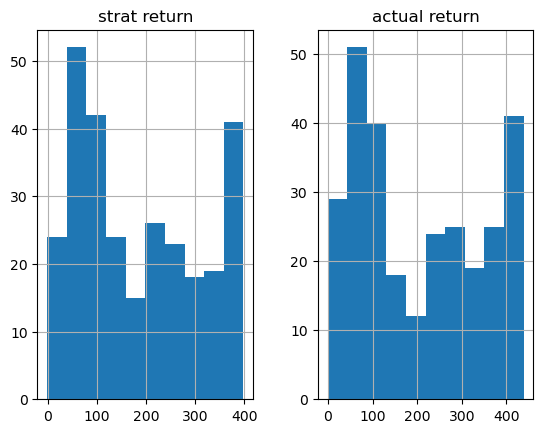

In [53]:
fig = plt.figure()
fig.suptitle('Backtest - strat return vs actual return histogram')
backtest[['strat return','actual return']].cumsum().hist()
save_fig('Backtest - strat return vs actual return histogram',tight_layout=False)
plt.show()

Saving figure Backtest - strat return vs actual return


<Figure size 640x480 with 0 Axes>

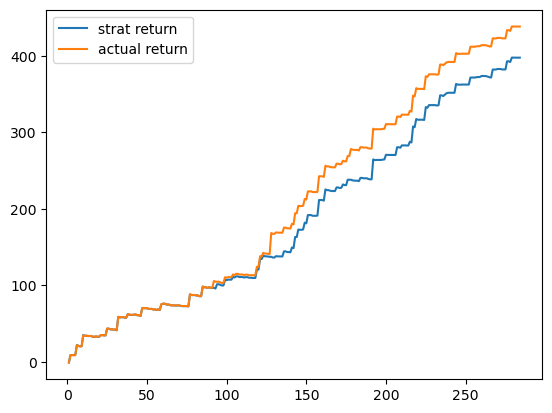

In [54]:
fig = plt.figure()
fig.suptitle('Backtest - strat return vs actual return')
backtest[['strat return','actual return']].cumsum().plot()
save_fig('Backtest - strat return vs actual return', tight_layout=False)
plt.show()

We deviated at the end too early. potential can kicking for what's about to be a bullish movement in the future...
